<a href="https://colab.research.google.com/github/johannieto28/chatopia/blob/main/Copia_de_Taller1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos Geneticos

Para el problema siguiente, haga:

1. Codifique un GA simple para resolver el problema. Para hacer esto, necesita codificar el problema, usar un cruce de un solo punto y un cambio de bits o una mutación de 2 opciones, usar una forma de selección de ruleta o selección de torneo, establecer un tamaño de población y seleccionar un criterio de parada.
2. Ejecute su GA.
3. Realice los siguientes cambios en su código GA (uno por uno) y compare el resultados.
* Cambiar los puntos de partida iniciales (soluciones iniciales) diez veces
* Cambiar la probabilidad de cruce dos veces
* Cambiar la probabilidad de mutación dos veces
* Cambiar el tamaño de la población dos veces
* Cambie la semilla del número aleatorio diez veces
4. Incluya su código con su tarea.
5. Indique que el porcentaje de cada miembro del equipo contribuye a este asignación (solo si trabaja con otros).
6. No copie el trabajo de otro equipo/individuo. Cualquiera/cualquier equipo que viole este reglamento recibirá una calificación de cero para este taller.
Incluyo el óptimo global para cada problema como referencia, pero no lo use en su metodología de solución.

## Problema

Dada un área que tiene una cantidad de discos que no se superponen esparcidos por su superficie, como se muestra en la figura 1,

![](https://github.com/LeidyMara/HPC_SquareMatrix/blob/main/fig01.jpg?raw=1)

Utilice un algoritmo genético para encontrar el disco de mayor radio que se puede colocar entre estos discos sin superponer ninguno de ellos.  Ver figura 2.

![](https://github.com/LeidyMara/HPC_SquareMatrix/blob/main/fig02.jpg?raw=1)

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

from deap import base, creator, tools, algorithms

from dataclasses import dataclass
from math import pi, asin, acos, sin, cos, fabs, sqrt

import numpy as np
import random

In [ ]:
# define.py

WINDOW_WIDTH     = 400
WINDOW_HEIGHT	   = 400

CROSSOVER_RATE   = 0.8
MUTATION_RATE    = 0.05
NGEN = 100

NUM_ELITE        = 4
NUM_COPIES_ELITE = 1

POP_SIZE         = 150

GENE_LENGTH      = 10
CHROMO_LENGTH    = 3 * GENE_LENGTH

NUM_CIRCLES      = 20
MIN_RAD          = 10
MAX_RAD          = 30

BIT_MULTIPLIER   = pow(2, GENE_LENGTH)

In [ ]:
# define 2D point
@dataclass
class Point:
	x : float
	y : float

	def distance(self, other):
		if not isinstance(other, Point):
			raise RuntimeError('no es un punto')
		x1, y1 = self.x, self.y
		x2, y2 = other.x, other.y
		return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


# define a circle
@dataclass
class Circle:
	center : Point
	radius : float

	@property
	def area(self):
		return pi * self.radius ** 2

	def distance(self, other):
		if not isinstance(other, Circle):
			raise RuntimeError('no es un circulo')
		p1, p2 = self.center, other.center
		return p1.distance(p2)

	def is_overlapped(self, other):
		'''
		returns True if the two circles overlap
		'''
		dist = self.distance(other)
		r1 = self.radius
		r2 = other.radius

		if dist < (r1+r2) or dist < fabs(r1-r2):
			return True
		return False

	def is_enclosed(self, other):
		'''
		returns True if one circle encloses the other
		'''
		dist = self.distance(other)
		r1 = self.radius
		r2 = other.radius

		if dist < fabs(r1-r2):
			return True
		return False

	def intersection_points(self, other):
		'''
		Given two circles this function calculates the
		intersection points of any overlap.

		returns [] if no overlap found

		see http://astronomy.swin.edu.au/~pbourke/geometry/2circle/
		'''
		# check to see if they overlap
		if not self.is_overlapped(other):
			return []

		# calculate the distance between the circle centers
		d  = self.distance(other)
		r1 = self.radius
		r2 = other.radius

		# Now calculate the distance from the center of each
		# circle to the center of the line which connects
		# the intersection points.
		a = (r1 - r2 + d ** 2) / (2 * d)
		b = (r2 - r1 + d ** 2) / (2 * d)

		# MAYBE A TEST FOR EXACT OVERLAP?

		# calculate the point P2 which is the center of the
		# line which connects the intersection points
		x1, y1 = self.center.x, self.center.y
		x2, y2 = other.center.x, other.center.y

		p2X = x1 + a * (x2 - x1) / d
		p2Y = y1 + a * (y2 - y1) / d

		points = []

		# calculate first point
		h1 = sqrt(r1 ** 2 - a ** 2)

		p3X = p2X - h1 * (y2 - y1) / d
		p3Y = p2Y + h1 * (x2 - x1) / d
		points.append(Point(p3X, p3Y))

		# calculate second point
		h2 = sqrt(r2 ** 2 - a ** 2)

		p4X = p2X + h2 * (y2 - y1) / d
		p4Y = p2Y - h2 * (x2 - x1) / d
		points.append(Point(p4X, p4Y))

		return points

	def intersection_area(self, other):
		'''
		Tests to see if two circles overlap and if so
		calculates the area defined by the union

		see http://mathforum.org/library/drmath/view/54785.html
		'''
		# first calculate the intersection points

		points = self.intersection_points(other)

		if len(points) == 0:
			return 0	# no overlap

		# calculate the distance between the circle centers
		d  = self.distance(other)
		r1 = self.radius
		r2 = other.radius

		# find the angles given that A and B are the two circle
		# centers and C and D are the intersection points
		CBD = 2 * acos((r2*r2 + d*d - r1*r1) / (r2 * d * 2))

		CAD = 2 * acos((r1*r1 + d*d - r2*r2) / (r1 * d * 2))

		# Then we find the segment of each of the circles cut off
		# by the chord CD, by taking the area of the sector of the
		# circle BCD and subtracting the area of triangle BCD.
		# Similarly we find the area of the sector ACD and subtract
		# the area of triangle ACD.

		return 0.5*(CBD*r2*r2 - r2*r2*sin(CBD) + CAD*r1*r1 - r1*r1*sin(CAD))

def init_circles(num_circles, min_rad, max_rad):
	'''
	create a number of randomly sized circles
	'''
	circles = []

	for _ in range(num_circles):
		r = random.randint(min_rad,max_rad)
		x = random.randint(r,WINDOW_WIDTH-r)
		y = random.randint(r,WINDOW_HEIGHT-r-30)

		c1 = Circle(Point(x,y), r)

		is_overlapped = False
		for c in circles:
			if c.is_overlapped(c1):
				is_overlapped = True
				break

		if not is_overlapped:
			circles.append(c1)

	return circles

In [ ]:
circles = init_circles(NUM_CIRCLES, MIN_RAD, MAX_RAD)

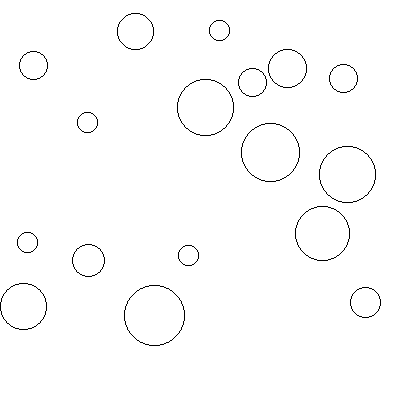

In [ ]:
img = Image.new('RGBA',
  (WINDOW_WIDTH, WINDOW_HEIGHT),
  (255,255,255))
draw = ImageDraw.Draw(img)

for c in circles:
  x, y = c.center.x, c.center.y
  r = c.radius
  draw.ellipse((x-r, y-r, x+r, y+r),
    outline=(0,0,0))

img

In [ ]:
def decode(individual):
  r, x, y = individual
  return Circle(Point(x,y),r)

def evalCircle(individual):
  c1 = decode(individual)
  area = c1.area

  for c in circles:
    if c.is_overlapped(c1):
     # area *= -1 (penalización, area negativa)
      break

  return area,

In [ ]:
# Define el problema como un problema de maximización
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define las funciones auxiliares
def random_bit():
    return random.randint(0, 1)

def random_gene():
    return [random_bit() for _ in range(GENE_LENGTH)]

def decode_gene(gene):
    return int("".join(map(str, gene)), 2) / BIT_MULTIPLIER

def evaluate(individual):
    # Decodifica el cromosoma en un círculo
    circle_radius = decode_gene(individual)
    circle = Circle(Point(WINDOW_WIDTH // 2, WINDOW_HEIGHT // 2), circle_radius)

    # Calcula el área del círculo
    circle_area = circle.area

    # Calcula el área de superposición con otros círculos
    overlap_area = sum(circle.intersection_area(other) for other in circles)

    # El fitness es el área del círculo menos el área de superposición
    fitness = circle_area - overlap_area
    return fitness,

def crossover(ind1, ind2):
    # Cruce de un solo punto
    crossover_point = random.randint(1, CHROMO_LENGTH - 1)
    ind1[crossover_point:], ind2[crossover_point:] = ind2[crossover_point:], ind1[crossover_point:]
    return ind1, ind2

def mutate(individual):
    # Mutación de 2 opciones
    bit_to_mutate = random.randint(0, CHROMO_LENGTH - 1)
    individual[bit_to_mutate] = random_bit()
    return individual

# Registra las operaciones genéticas
toolbox = base.Toolbox()
toolbox.register("attr_bool", random_bit)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=CHROMO_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

# Crea una población inicial
population = toolbox.population(n=POP_SIZE)

# Define las estadísticas para el registro
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)

# Evoluciona la población
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE,
                                           ngen=NGEN, verbose=True)

# Obtiene el mejor individuo de la última generación
best_individual = tools.selBest(population, k=1)[0]
best_circle_radius = decode_gene(best_individual)
best_circle = Circle(Point(WINDOW_WIDTH // 2, WINDOW_HEIGHT // 2), best_circle_radius)

print("El mejor círculo tiene un radio de:", best_circle_radius)

ValueError: math domain error

In [ ]:
def draw_circles(circles, best_circle=None):
    img = Image.new('RGB', (WINDOW_WIDTH, WINDOW_HEIGHT), color='white')
    draw = ImageDraw.Draw(img)
    for circle in circles:
        x0 = int(circle.center.x - circle.radius)
        y0 = int(circle.center.y - circle.radius)
        x1 = int(circle.center.x + circle.radius)
        y1 = int(circle.center.y + circle.radius)
        draw.ellipse([x0, y0, x1, y1], outline='black', width=1)
    if best_circle:
        x0 = int(best_circle.center.x - best_circle.radius)
        y0 = int(best_circle.center.y - best_circle.radius)
        x1 = int(best_circle.center.x + best_circle.radius)
        y1 = int(best_circle.center.y + best_circle.radius)
        draw.ellipse([x0, y0, x1, y1], outline='red', width=2)
    img.show()

# Llama a la función draw_circles con los círculos generados y el mejor círculo encontrado
draw_circles(circles, best_circle)
